In [9]:
%%bash
test -d ./data/used-cars/ || 
kaggle datasets download -d nehalbirla/vehicle-dataset-from-cardekho -p ./data/ && 
unzip ./data/vehicle-dataset-from-cardekho.zip -d ./data/used-cars/ &&
rm ./data/vehicle-dataset-from-cardekho.zip


Archive:  ./data/vehicle-dataset-from-cardekho.zip
  inflating: ./data/used-cars/CAR DETAILS FROM CAR DEKHO.csv  
  inflating: ./data/used-cars/Car details v3.csv  
  inflating: ./data/used-cars/car data.csv  


100%|██████████| 227k/227k [00:00<00:00, 10.2MB/s]


In [64]:
import pandas as pd
from matplotlib import pyplot  as plt
import numpy as np

In [435]:
fn = "./data/used-cars/Car details v3.csv"

df = pd.read_csv(fn)
df = df.dropna()
df = df.loc[df.selling_price < 2500000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7603 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           7603 non-null   object 
 1   year           7603 non-null   int64  
 2   selling_price  7603 non-null   int64  
 3   km_driven      7603 non-null   int64  
 4   fuel           7603 non-null   object 
 5   seller_type    7603 non-null   object 
 6   transmission   7603 non-null   object 
 7   owner          7603 non-null   object 
 8   mileage        7603 non-null   object 
 9   engine         7603 non-null   object 
 10  max_power      7603 non-null   object 
 11  torque         7603 non-null   object 
 12  seats          7603 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 831.6+ KB


In [436]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [437]:
# Preprocessing
df['mileage'] = df['mileage'].str.extract("([\d\.]+)\s[\w/]+").astype(float)
df = pd.concat([df, pd.get_dummies(df['owner'], prefix="owner_")], axis=1)
df = pd.concat([df, pd.get_dummies(df['transmission'], prefix="transmission_")], axis=1)
df = pd.concat([df, pd.get_dummies(df['fuel'], prefix="fuel_")], axis=1)
df = pd.concat([df, pd.get_dummies(df['seller_type'], prefix="seller_type_")], axis=1)
df['engine'] = df['engine'].str.extract("([\d\.]+)\sCC").astype(float)

In [439]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats', 'owner__First Owner', 'owner__Fourth & Above Owner',
       'owner__Second Owner', 'owner__Test Drive Car', 'owner__Third Owner',
       'transmission__Automatic', 'transmission__Manual', 'fuel__CNG',
       'fuel__Diesel', 'fuel__LPG', 'fuel__Petrol', 'seller_type__Dealer',
       'seller_type__Individual', 'seller_type__Trustmark Dealer'],
      dtype='object')

In [440]:
y_col = "selling_price"
x_col = [
    'year', 
    'km_driven', 
    
    'fuel__CNG',
    'fuel__Diesel',
    'fuel__LPG',
    'fuel__Petrol',
    
    'seller_type__Dealer',
    'seller_type__Individual',
    'seller_type__Trustmark Dealer',
    
    'transmission__Automatic', 
    'transmission__Manual',
    
    'owner__Test Drive Car',
    'owner__First Owner', 
    'owner__Second Owner',
    'owner__Third Owner',
    'owner__Fourth & Above Owner',
        
    'mileage', 
    'engine', 
    # 'max_power', 
    # 'torque',
    'seats', 
]

In [441]:
# Train/test split
y = df[y_col].values.astype(float)
x = df[x_col].values.astype(float)

mask = [random.random() > 0.2 for _ in range(0, len(df))]
mask_test = [not x for x in mask]
x_train = x[mask]
y_train = y[mask]
x_test = x[mask_test]
y_test = y[mask_test]

assert(y_train.shape[0] + y_test.shape[0] == len(df))

In [442]:
# Standardization
means = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)

x_train_std = (x_train - means) / std
x_test_std = (x_test - means) / std

In [443]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [444]:
model = Sequential([
    Dense(
        input_shape=(x_train.shape[1],), 
        units=128, 
        activation="relu",
    ),
    Dropout(.2),
    Dense(
        units=64, 
        activation="relu",
    ),
    Dropout(.2),
    Dense(
        units=32, 
        activation="relu",
    ),
    Dropout(.2),
    Dense(
        units=1, 
        activation="linear",
        bias_initializer="zeros",
    ),
    ])

In [445]:
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error",],
)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 128)               2560      
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 32)                2080      
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_54 (Dense)            (None, 1)               

In [446]:
BATCH_SIZE = 32
EPOCHS = 150

model.fit(
    x=x_train_std,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=[x_test_std, y_test],
    verbose=0
)

history = model.history.history

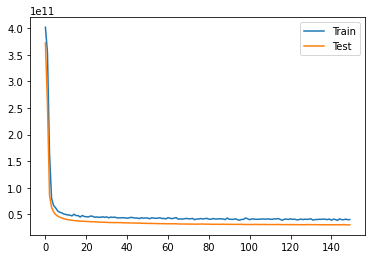

In [447]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.legend(["Train", "Test",])

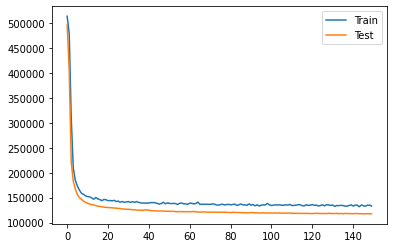

In [448]:
plt.plot(history["mean_absolute_error"])
plt.plot(history["val_mean_absolute_error"])
plt.legend(["Train", "Test",])

In [449]:
print("Min mean error", np.min(history["val_mean_absolute_error"]))

Min mean error 117240.3359375


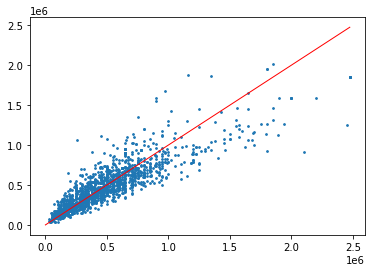

In [450]:
predictions = model.predict(x_test_std)

plt.figure()
plt.scatter(y_test, predictions, s=3)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], color="red", lw=1)